In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
#%matplotlib qt
from PIL import Image
from sklearn.cross_validation import train_test_split
from pybrain.tools.shortcuts import buildNetwork
from pybrain.tools.shortcuts import SigmoidLayer
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
import pickle

In [2]:
def avr_img(img,rows,cols):
    mean_image=np.zeros((rows,cols))
    dr,dc=img.shape[0]/rows,img.shape[1]/cols
    for r in range(0,rows):
        for c in range(0,cols):
            mean_image[r,c]=img[r*dr:r*dr+dr,c*dc:c*dc+dc].mean()
    return mean_image
def show(image):
    plt.imshow(image,cmap=plt.cm.gray,interpolation='none')
    plt.show()
def convert_to_array(images,rows,cols):
    for i in range(len(images)):
        images[i]=images[i].reshape(rows*cols)
    images_list=[]
    for i in range(len(images)):
        images_list.append(images[i])
    images_list=np.array(images_list)
    return images_list
def rgb_convert_to_array(small_images,rows,cols):
    for i in range(len(small_images)):
        small_images[i]=small_images[i].reshape(rows*cols,3)
        small_images[i]=small_images[i].reshape(rows*cols*3)
    images_list=[]
    for i in range(len(small_images)):
        images_list.append(small_images[i])
    images_list=np.array(images_list)
    return images_list
def get_err_in_percent(net,ds):
    h=net.activateOnDataset(ds)
    return 100-sum(h.argmax(axis=1)==ds['target'].argmax(axis=1))/float(ds['target'].shape[0])*100

In [12]:
images=[]
location='F:/Users/Nadav/OneDrive/WinPython-64bit-2.7.10.2/notebooks/docs/Check_Group/'
for k in range(150):
    name=str(k)+'.JPG'
    img = Image.open(location+name)
    images.append(img)
small_images = copy.deepcopy(images)
k=1
for i in range(len(small_images)):
    cols,rows=small_images[i].size
    small_images[i].thumbnail((cols/320*k, rows/320*k), Image.ANTIALIAS)
for i in range(len(small_images)):
    small_images[i]=np.array(small_images[i])
images_arr=[]
for i in range(len(images)):
    images_arr.append(np.array(images[i]))
small_images=np.array(small_images)

In [ ]:
small_images_90=[np.rot90(i,-1) for i in small_images]
small_images_90=np.array(small_images_90)
small_images_180=[np.rot90(i,-2) for i in small_images]
small_images_180=np.array(small_images_180)
small_images_270=[np.rot90(i,-3) for i in small_images]
small_images_270=np.array(small_images_270)

In [ ]:
small_images=rgb_convert_to_array(small_images,4,3)
small_images_90=rgb_convert_to_array(small_images_90,4,3)
small_images_180=rgb_convert_to_array(small_images_180,4,3)
small_images_270=rgb_convert_to_array(small_images_270,4,3)

In [13]:
small_images_list=[]
for i in range(len(small_images)):
    small_images_list.append(small_images[i].reshape(36))
small_images=small_images_list

In [16]:
small_images_target=[]
for i in range(15):
    small_images_target.append([0,1,0,0])
for i in range(15,30):
    small_images_target.append([1,0,0,0])
for i in range(30,40):
    small_images_target.append([0,0,0,1])
for i in range(40,45):
    small_images_target.append([0,0,1,0])
for i in range(45,110):
    small_images_target.append([1,0,0,0])
for i in range(110,130):
    small_images_target.append([0,1,0,0])
for i in range(130,145):
    small_images_target.append([0,0,0,1])
for i in range(145,150):
    small_images_target.append([0,0,1,0])

In [17]:
small_images_target=np.array(small_images_target)
total_small_images=np.vstack((small_images))
total_small_images_targets=np.vstack((small_images_target))
small_images_inputs_targets=np.column_stack((range(len(total_small_images)),total_small_images,total_small_images_targets))
x=small_images_inputs_targets[:,:-4]
y=small_images_inputs_targets[:,-4:]
small_ds=SupervisedDataSet(36,4)
small_ds.setField('input',x[:,1:])
small_ds.setField('target',y)
small_indexes=x[:,0]
small_ds.saveToFile('small_check_group_ds_4X3X3')
np.save('small_check_group_indexes_4X3X3.npy',small_indexes)

In [7]:
small_train_ds=SupervisedDataSet.loadFromFile('small_train_google_ds_4X3X3')
small_test_ds=SupervisedDataSet.loadFromFile('small_test_google_ds_4X3X3')
small_train_indexes=np.load('small_train_indexes_4X3X3.npy')
small_test_indexes=np.load('small_test_indexes_4X3X3.npy')

In [18]:
f=open('small_net_4X3X3.net','r')
small_net=pickle.load(f)

In [19]:
result=get_err_in_percent(small_net,small_ds)
result

19.333333333333343

In [30]:
small_h=small_net.activateOnDataset(small_ds)
small_h_list=[]
for i in range(small_h.shape[0]):
    small_h_list.append(np.where(small_h[i]==max(small_h[i]),1,0))
small_h_arr=np.array(small_h_list)

In [8]:
small_train_pics=[]
for i in range(len(small_train_ds['input'])):
    index=small_train_indexes[i]
    index=int(index)
    if index<149 or (index>=300 and index<=449):
        if index%150<=74:
            small_train_pics.append(small_train_ds['input'][i].reshape(4,3,3))
        else:
            small_train_pics.append(small_train_ds['input'][i].reshape(3,4,3))
    else:
        if index%150<=74:
            small_train_pics.append(small_train_ds['input'][i].reshape(3,4,3))
        else:
            small_train_pics.append(small_train_ds['input'][i].reshape(4,3,3))
failed_indexes=[]
for i in range(len(small_train_ds['target'])):
    if(sum(abs(small_train_ds['target'][i]-small_h_train_arr[i]))!=0):
        failed_indexes.append(i)

true value: [0 0 1 0] net value: [0 0 0 1] 385


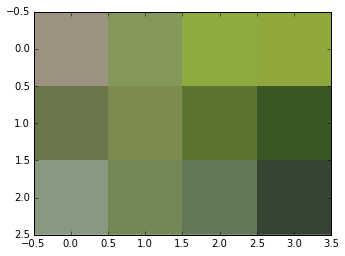

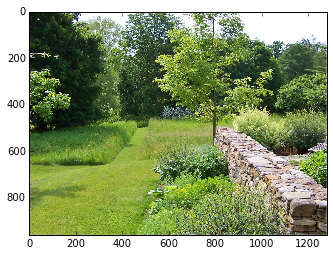

In [10]:
from IPython.html.widgets import interact
@interact
def ss(i=(0,len(failed_indexes)-1)):
    k=failed_indexes[i]
    print "true value:",small_train_ds['target'][k],"net value:", small_h_train_arr[k], small_train_indexes[k]
    show(256-small_train_pics[k])
    show(images[int(small_train_indexes[k])%150])

true value: [0 1 0 0] net value: [0 1 0 0] 9


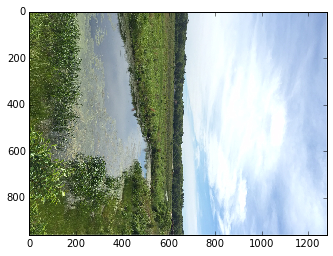

In [43]:
k=9
print "true value:",small_ds['target'][k],"net value:", small_h_arr[k], small_indexes[k]
show(images[k])

In [67]:
k=0
location='F:/Users/Nadav/OneDrive/WinPython-64bit-2.7.10.2/notebooks/docs/Check_Group_Fixed_By_Net/'
for i in small_h_arr:
    name=str(k)+'.jpg'
    if sum(abs(i-[1,0,0,0]))==0:
        images[k].save(location+name)
        k+=1
    elif sum(abs(i-[0,1,0,0]))==0:
        images[k].rotate(90).save(location+name)
        k+=1
    elif sum(abs(i-[0,0,1,0]))==0:
        images[k].rotate(180).save(location+name)
        k+=1
    else:
        images[k].rotate(270).save(location+name)
        k+=1

In [66]:
sum(abs(small_h_arr[9]-[0,1,0,0]))==0

True

In [63]:
small_h_arr[0]

array([0, 0, 1, 0])

In [ ]:
location='F:/Users/Nadav/OneDrive/WinPython-64bit-2.7.10.2/notebooks/docs/Check_Group/'
for k in range(150):
    name=str(k)+'.JPG'
    img = Image.open(location+name)